# Sample of NCI1 dataset graph classification

In [1]:
# --------------------------------------------------
# Insatall
# --------------------------------------------------
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.5 MB/s eta 0:00:00


In [2]:
# --------------------------------------------------
# Libraries
# --------------------------------------------------
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.utils import scatter
from torch_geometric.utils import to_networkx
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset

Processing...
Done!


--------------------------------------------------------------------------------------------------------------------------
The NCI1 dataset comes from the cheminformatics domain, where each input graph is used as representation of a
chemical compound: each vertex stands for an atom of the molecule, and edges between vertices represent bonds
between atoms. This dataset is relative to anti-cancer screens where the chemicals are assessed as positive or negative
to cell lung cancer. Each vertex has an input label representing the corresponding atom type, encoded by a one-hot-
encoding scheme into a vector of 0/1 elements.
--------------------------------------------------------------------------------------------------------------------------
Number of graphs: 4110
Dimension of node features: 37
Number of POSITIVE graphs: 2057
Number of NEGATIVE graphs: 2053
Details:
All graphs are undirected. Graphs of NCI1 dataset have no edge features.


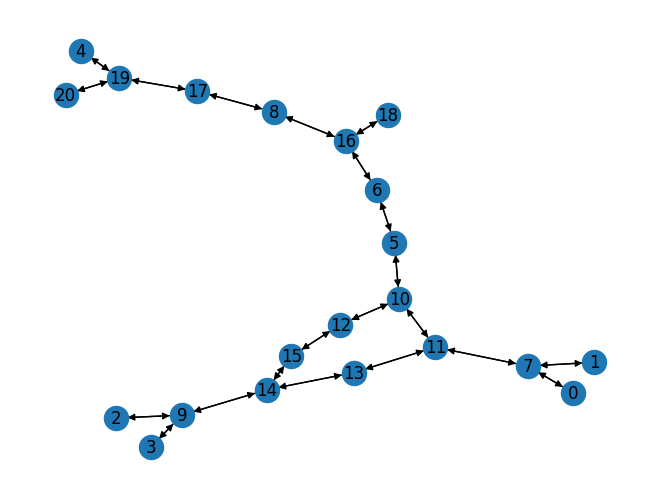

In [3]:
# --------------------------------------------------
# Load dataset
# --------------------------------------------------

# Load NCI1 datset
dataset = TUDataset(root='', name='NCI1')

# Explanation and show sample graph
idx = 0
sample_data = dataset[idx]
graph_labels = [dataset[i].y.item() for i in range(len(dataset))]

print("--------------------------------------------------------------------------------------------------------------------------")
print("The NCI1 dataset comes from the cheminformatics domain, where each input graph is used as representation of a")
print("chemical compound: each vertex stands for an atom of the molecule, and edges between vertices represent bonds")
print("between atoms. This dataset is relative to anti-cancer screens where the chemicals are assessed as positive or negative")
print("to cell lung cancer. Each vertex has an input label representing the corresponding atom type, encoded by a one-hot-")
print("encoding scheme into a vector of 0/1 elements.")
print("--------------------------------------------------------------------------------------------------------------------------")
print(f"Number of graphs: {len(dataset)}")
print(f"Dimension of node features: {sample_data.x.shape[1]}")
print(f"Number of POSITIVE graphs: {np.sum(graph_labels)}")
print(f"Number of NEGATIVE graphs: {len(dataset) - np.sum(graph_labels)}")
print("Details:")
print("All graphs are undirected. Graphs of NCI1 dataset have no edge features.")
nx.draw(to_networkx(sample_data), with_labels = True)

# Train-test split

In [4]:
# --------------------------------------------------
# Split
# --------------------------------------------------
dataset = dataset.shuffle()
n_train = len(dataset) // 10 * 9
n_test = len(dataset) - n_train
train_dataset = dataset[:n_train]
test_dataset = dataset[n_train:]

print(f"Train dataset size: {len(train_dataset)}, Proportion of POSITIVE graph: {np.sum([train_dataset[i].y.item() for i in range(len(train_dataset))])/len(train_dataset):.3f}")
print(f"Test dataset size:  {len(test_dataset)},  Proportion of POSITIVE graph: {np.sum([test_dataset[i].y.item() for i in range(len(test_dataset))])/len(test_dataset):.3f}")

Train dataset size: 3699, Proportion of POSITIVE graph: 0.503
Test dataset size:  411,  Proportion of POSITIVE graph: 0.482


# Model result

In [5]:
model_result = pd.DataFrame()

# Baseline model
#### Graph embedding: Sum of node features (Embedding represents the number of each atom included in the graph)
#### Classification model: MLP

In [6]:
# --------------------------------------------------
# Settings
# --------------------------------------------------
batch_size = 256
lr = 0.001
epochs = 50
thereshhold = 0.5

In [7]:
# --------------------------------------------------
# Data processing
# --------------------------------------------------

# Caluculate sum of node features
train_graph_embedding = [train_dataset[i].x.sum(axis = 0).view(1, -1) for i in range(len(train_dataset))]
test_graph_embedding = [test_dataset[i].x.sum(axis = 0).view(1, -1) for i in range(len(test_dataset))]

# Concatenate
train_graph_embedding = torch.cat(train_graph_embedding, dim = 0)
test_graph_embedding = torch.cat(test_graph_embedding, dim = 0)

# Graph label
train_y = torch.cat([train_dataset[i].y.view(1, -1) for i in range(len(train_dataset))], dim = 0)
test_y = torch.cat([test_dataset[i].y.view(1, -1) for i in range(len(test_dataset))], dim = 0)

In [8]:
# --------------------------------------------------
# Model and Dataset
# --------------------------------------------------

# Define model structure
class MLP(nn.Module):
    def __init__(self, d_input, d_hidden1, d_output):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(d_input, d_hidden1),
            nn.ReLU(),
            nn.Linear(d_hidden1, d_output)
        )

    def forward(self, x):
        return self.main(x)

# Define dataset
class GraphDataset(Dataset):
    def __init__(self, train_X, test_X, train_y, test_y):
        # Attr
        self.train_X = train_X
        self.test_X = test_X
        self.train_y = train_y
        self.test_y = test_y
        # Standarization
        self.scaler_X = StandardScaler()
        self.standarized_train_X = self.scaler_X.fit_transform(self.train_X)
        self.standarized_test_X = self.scaler_X.transform(self.test_X)
        # To tensor
        self.standarized_train_X = torch.FloatTensor(self.standarized_train_X)
        self.standarized_test_X = torch.FloatTensor(self.standarized_test_X)

    def __getitem__(self, idx):
        return self.standarized_train_X[idx], self.train_y[idx]

    def __len__(self):
        return len(self.standarized_train_X)

In [9]:
# --------------------------------------------------
# Instantiation of pytorch components
# --------------------------------------------------

# Model
model = MLP(d_input = train_graph_embedding.size()[1], d_hidden1 = 8, d_output = 1)

# Dataset, Dataloader
graph_dataset = GraphDataset(train_graph_embedding, test_graph_embedding, train_y, test_y)
dataloader = DataLoader(dataset = graph_dataset, batch_size = batch_size, shuffle = True)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

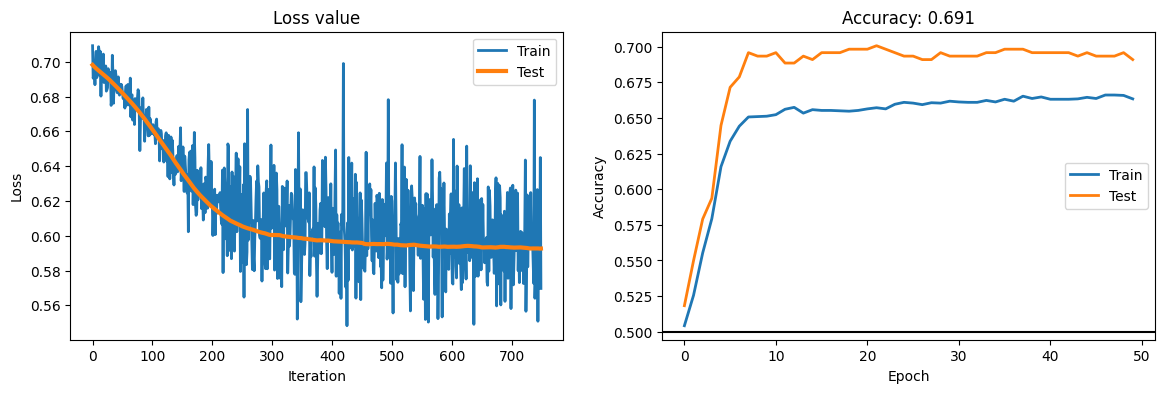

CPU times: user 7.13 s, sys: 82 ms, total: 7.21 s
Wall time: 11.6 s


In [10]:
%%time
# --------------------------------------------------
# Training
# --------------------------------------------------

# Training
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []
for epoch in range(epochs):
    for X, y in dataloader:
        # Training
        model.train()
        pred_y = model(X)
        loss = criterion(pred_y, y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())

        # Testing
        model.eval()
        with torch.no_grad():
            test_pred_y = model(graph_dataset.standarized_test_X)
            test_loss = criterion(test_pred_y, graph_dataset.test_y.float())
            test_loss_list.append(float(test_loss))

    # Accuracy
    model.eval()
    with torch.no_grad():
        # Train accuracy
        train_pred = torch.sigmoid(model(graph_dataset.standarized_train_X)).numpy().ravel()
        binary_train_pred = [1 if i >= thereshhold else 0 for i in train_pred]
        train_y = graph_dataset.train_y.numpy().ravel()
        train_accuracy = np.sum(binary_train_pred == train_y)/len(train_y)
        train_accuracy_list.append(train_accuracy)
        # Test accuracy
        test_pred = torch.sigmoid(model(graph_dataset.standarized_test_X)).numpy().ravel()
        binary_test_pred = [1 if i >= thereshhold else 0 for i in test_pred]
        test_y = graph_dataset.test_y.numpy().ravel()
        test_accuracy = np.sum(binary_test_pred == test_y)/len(test_y)
        test_accuracy_list.append(test_accuracy)

# plot
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].plot(train_loss_list, label = "Train", linewidth = 2)
ax[0].plot(test_loss_list, label = "Test", linewidth = 3)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss value")
ax[1].plot(train_accuracy_list, label = "Train", linewidth = 2)
ax[1].plot(test_accuracy_list, label = "Test", linewidth = 2)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].set_title(f"Accuracy: {test_accuracy_list[-1]:.3f}")
ax[1].axhline(0.5, color = 'k')
plt.show()

# Save accuracy
model_result = pd.concat([model_result,
                          pd.DataFrame([["MLP", test_accuracy_list[-1]]], columns = ["Model", "Test accuracy"])])

# Logistic regression
#### Graph embedding: Sum of node features (Embedding represents the number of each atom included in the graph)
#### Classification model: MLP

In [11]:
# --------------------------------------------------
# Data processing
# --------------------------------------------------

# Caluculate sum of node features
train_graph_embedding = [train_dataset[i].x.sum(axis = 0).view(1, -1) for i in range(len(train_dataset))]
test_graph_embedding = [test_dataset[i].x.sum(axis = 0).view(1, -1) for i in range(len(test_dataset))]

# Concatenate
train_graph_embedding = torch.cat(train_graph_embedding, dim = 0).numpy()
test_graph_embedding = torch.cat(test_graph_embedding, dim = 0).numpy()

# Graph label
train_y = torch.cat([train_dataset[i].y.view(1, -1) for i in range(len(train_dataset))], dim = 0).numpy()
test_y = torch.cat([test_dataset[i].y.view(1, -1) for i in range(len(test_dataset))], dim = 0).numpy()

In [12]:
# --------------------------------------------------
# Training
# --------------------------------------------------

# Grid serch
serch_param = {
    "C": [10**i for i in range(-4,4)],
    "penalty": ["l1", "l2"],
}

grid_serch_model = GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid = serch_param, cv = 5)
grid_serch_model.fit(train_graph_embedding, train_y.ravel())
print("----------------- Grid serch result -----------------")
print(f"Best score: {grid_serch_model.best_score_:.3f}")
print(f"Best parameters: {grid_serch_model.best_params_}")

# Trainig with best parameters
model = LogisticRegression(solver = 'liblinear', **grid_serch_model.best_params_)
model.fit(train_graph_embedding, train_y.ravel())

# Accuracy
train_accuracy = model.score(train_graph_embedding, train_y.ravel())
test_accuracy = model.score(test_graph_embedding, test_y.ravel())
print("----------------- Training result -----------------")
print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")

# Save accuracy
model_result = pd.concat([model_result,
                          pd.DataFrame([["Linear logistic regression", test_accuracy]], columns = ["Model", "Test accuracy"])])

----------------- Grid serch result -----------------
Best score: 0.649
Best parameters: {'C': 0.1, 'penalty': 'l2'}
----------------- Training result -----------------
Train accuracy: 0.652
Test accuracy: 0.689


# Simple Graph Convolution
#### Graph embedding: Simple Graph Convolution
#### Classification model: MLP
#### Reference: Simplifying Graph Convolutional Networks, https://arxiv.org/abs/1902.07153

In [13]:
# --------------------------------------------------
# Settings
# --------------------------------------------------
K = 8
pooling_type = 'average'
batch_size = 256
lr = 0.001
epochs = 50
thereshhold = 0.5

In [14]:
# --------------------------------------------------
# Utils
# --------------------------------------------------

def get_normalized_adjecency_matrix(data):
    """
    data: torch_geometric graph data
    """
    # Adjecency matrix
    A = np.diag([1 for i in range(data.x.size()[0])])
    for edge in data.edge_index.T:
        A[int(edge[0]), int(edge[1])] = 1
        A[int(edge[1]), int(edge[0])] = 1
    # Degree matrix
    D = np.diag(A.sum(axis = 1))
    # Normalized adjecency matrix
    normalized_A = np.linalg.inv(np.sqrt(D))@A@np.linalg.inv(np.sqrt(D))
    return normalized_A

def power_matrix(X, p):
    """
    A function to to calculate X^p
    """
    C = np.eye(X.shape[0])
    temp = X
    while p > 0:
        if p%2 == 1:
            C = C@temp
        p = p//2
        temp = temp@temp
    return C

def get_node_embedding(X, A):
    """
    X: Node feature matrix
    A: the matrix obtained by raising the normalized adjacency matrix to the power of K
    """
    return A@X

def pooling(G, type = "average"):
    """
    G: Node embeding
    type: pooling type, average or max
    """
    if type == "average":
        return G.mean(axis = 0).reshape(1, -1)
    elif  type == "max":
        return G.max(axis = 0).reshape(1, -1)
    else:
        raise ValueError(type)

def simple_graph_convolution(dataset, power, pooling_type):
    """
    Get graph embedding by Simple Graph Convolution.
    return: (n*d) graph emmbeding matrix, (n*1) graph label vector
    dataset: TUDataset
    """
    graph_rabel_list = []
    for i in range(len(dataset)):
        # Graph embedding
        A = get_normalized_adjecency_matrix(dataset[i])
        AK = power_matrix(A, power)
        Z = get_node_embedding(dataset[i].x.numpy(), AK)
        Z = pooling(Z, type = pooling_type)
        if i == 0:
            graph_embdding = Z
        else:
            graph_embdding = np.concatenate([graph_embdding, Z], axis = 0)
        # Graph label
        graph_rabel_list.append(dataset[i].y.numpy()[0])

    return graph_embdding, np.array(graph_rabel_list).reshape(-1, 1)

In [15]:
# --------------------------------------------------
# Model and Dataset
# --------------------------------------------------

# Define model structure
class MLP(nn.Module):
    def __init__(self, d_input, d_hidden1, d_output):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(d_input, d_hidden1),
            nn.ReLU(),
            nn.Linear(d_hidden1, d_output)
        )

    def forward(self, x):
        return self.main(x)

# Define dataset
class GraphDataset(Dataset):
    def __init__(self, train_X, test_X, train_y, test_y):
        # Attr
        self.train_X = train_X
        self.test_X = test_X
        self.train_y = train_y
        self.test_y = test_y
        # Standarization
        self.scaler_X = StandardScaler()
        self.standarized_train_X = self.scaler_X.fit_transform(self.train_X)
        self.standarized_test_X = self.scaler_X.transform(self.test_X)
        # To tensor
        self.standarized_train_X = torch.FloatTensor(self.standarized_train_X)
        self.standarized_test_X = torch.FloatTensor(self.standarized_test_X)
        self.train_y = torch.FloatTensor(self.train_y)
        self.test_y = torch.FloatTensor(self.test_y)

    def __getitem__(self, idx):
        return self.standarized_train_X[idx], self.train_y[idx]

    def __len__(self):
        return len(self.standarized_train_X)

In [16]:
%%time
# --------------------------------------------------
# Get graph embedding by simple graph convolution
# --------------------------------------------------
train_graph_embedding, train_y = simple_graph_convolution(train_dataset, K, pooling_type)
test_graph_embedding, test_y = simple_graph_convolution(test_dataset, K, pooling_type)

CPU times: user 15.7 s, sys: 13.6 s, total: 29.3 s
Wall time: 28.2 s


In [17]:
# --------------------------------------------------
# Instantiation of pytorch components
# --------------------------------------------------

# Model
model = MLP(d_input = train_graph_embedding.shape[1], d_hidden1 = 8, d_output = 1)

# Dataset, Dataloader
graph_dataset = GraphDataset(train_graph_embedding, test_graph_embedding, train_y, test_y)
dataloader = DataLoader(dataset = graph_dataset, batch_size = batch_size, shuffle = True)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

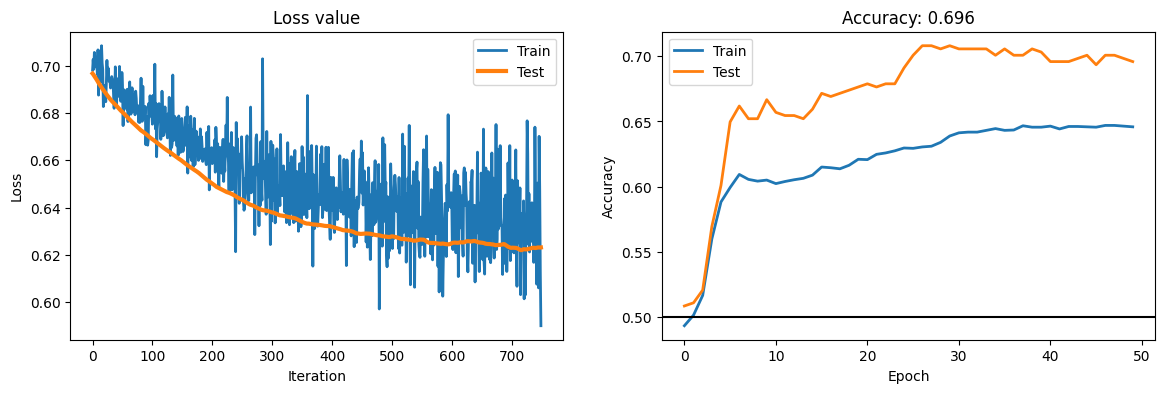

CPU times: user 3.81 s, sys: 186 ms, total: 3.99 s
Wall time: 3.81 s


In [18]:
%%time
# --------------------------------------------------
# Training
# --------------------------------------------------

# Training
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []
for epoch in range(epochs):
    for X, y in dataloader:
        # Training
        model.train()
        pred_y = model(X)
        loss = criterion(pred_y, y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())

        # Testing
        model.eval()
        with torch.no_grad():
            test_pred_y = model(graph_dataset.standarized_test_X)
            test_loss = criterion(test_pred_y, graph_dataset.test_y.float())
            test_loss_list.append(float(test_loss))

    # Accuracy
    model.eval()
    with torch.no_grad():
        # Train accuracy
        train_pred = torch.sigmoid(model(graph_dataset.standarized_train_X)).numpy().ravel()
        binary_train_pred = [1 if i >= thereshhold else 0 for i in train_pred]
        train_y = graph_dataset.train_y.numpy().ravel()
        train_accuracy = np.sum(binary_train_pred == train_y)/len(train_y)
        train_accuracy_list.append(train_accuracy)
        # Test accuracy
        test_pred = torch.sigmoid(model(graph_dataset.standarized_test_X)).numpy().ravel()
        binary_test_pred = [1 if i >= thereshhold else 0 for i in test_pred]
        test_y = graph_dataset.test_y.numpy().ravel()
        test_accuracy = np.sum(binary_test_pred == test_y)/len(test_y)
        test_accuracy_list.append(test_accuracy)

# plot
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].plot(train_loss_list, label = "Train", linewidth = 2)
ax[0].plot(test_loss_list, label = "Test", linewidth = 3)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss value")
ax[1].plot(train_accuracy_list, label = "Train", linewidth = 2)
ax[1].plot(test_accuracy_list, label = "Test", linewidth = 2)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].set_title(f"Accuracy: {test_accuracy_list[-1]:.3f}")
ax[1].axhline(0.5, color = 'k')
plt.show()

# Save accuracy
model_result = pd.concat([model_result,
                          pd.DataFrame([["SGC+MLP", test_accuracy_list[-1]]], columns = ["Model", "Test accuracy"])])

# Graph Isomorphism Network (GIN)


In [19]:
# --------------------------------------------------
# Settings
# --------------------------------------------------
epochs = 500
lr = 0.01
weight_decay = 1e-4
batch_size = 32

In [20]:
# --------------------------------------------------
# Model
# --------------------------------------------------

class MLP(nn.Module):
    def __init__(self, d_input, d_hidden1, d_output):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(d_input, d_hidden1),
            nn.BatchNorm1d(d_hidden1),
            nn.ReLU(),
            nn.Linear(d_hidden1, d_output),
            nn.BatchNorm1d(d_output),
            nn.ReLU()
        )

    def forward(self, input):
        return self.main(input)


class GIN(nn.Module):
    def __init__(self, d_input, d_hidden1, d_output):
        super(GIN, self).__init__()

        self.first_layer = MLP(d_input, d_hidden1, d_hidden1)
        self.conv1 = GINConv(MLP(d_hidden1, d_hidden1, d_hidden1))
        self.conv2 = GINConv(MLP(d_hidden1, d_hidden1, d_hidden1))
        self.conv3 = GINConv(MLP(d_hidden1, d_hidden1, d_hidden1))
        self.predictor = nn.Sequential(
            nn.Linear(d_hidden1, d_hidden1),
            nn.BatchNorm1d(d_hidden1),
            nn.ReLU(),
            nn.Linear(d_hidden1, d_output),
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.first_layer(x)
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        graph_embeddings = scatter(x, batch, dim = 0, reduce = 'max')
        res = self.predictor(graph_embeddings)
        return F.log_softmax(res, dim = 1)

In [21]:
# --------------------------------------------------
# Instantiation of pytorch components
# --------------------------------------------------

# Model
model = GIN(dataset.num_node_features, 32, dataset.num_classes)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = weight_decay)

# Loss function
criterion = nn.NLLLoss()

# Data loader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

100%|██████████| 500/500 [1:47:15<00:00, 12.87s/it]


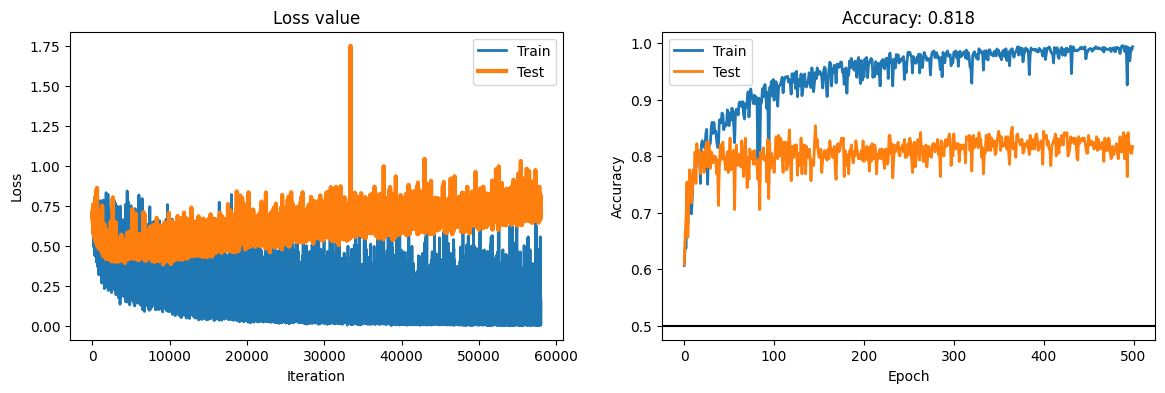

In [22]:
# --------------------------------------------------
# Training
# --------------------------------------------------

train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []
for epoch in tqdm(range(epochs)):
    for data in train_loader:
        # Training
        model.train()
        pred_y = model(data)
        loss = criterion(pred_y, data.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())

        # Testing
        model.eval()
        test_losses = []
        with torch.no_grad():
            for data in test_loader:
                test_pred_y = model(data)
                test_loss = criterion(test_pred_y, data.y)
                test_losses.append(float(test_loss))
        test_loss_list.append(np.mean(test_losses))

    # Accuracy
    model.eval()
    with torch.no_grad():
        # Train accuracy
        train_accuracy = 0
        for data in train_loader:
            pred = model(data).max(1)[1]
            train_accuracy += pred.eq(data.y).sum().item()
        train_accuracy = train_accuracy/len(train_dataset)
        train_accuracy_list.append(train_accuracy)
        # Test accuracy
        test_accuracy = 0
        for data in test_loader:
            pred = model(data).max(1)[1]
            test_accuracy += pred.eq(data.y).sum().item()
        test_accuracy = test_accuracy/len(test_dataset)
        test_accuracy_list.append(test_accuracy)

# plot
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].plot(train_loss_list, label = "Train", linewidth = 2)
ax[0].plot(test_loss_list, label = "Test", linewidth = 3)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss value")
ax[1].plot(train_accuracy_list, label = "Train", linewidth = 2)
ax[1].plot(test_accuracy_list, label = "Test", linewidth = 2)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].set_title(f"Accuracy: {test_accuracy_list[-1]:.3f}")
ax[1].axhline(0.5, color = 'k')
plt.show()

# Save accuracy
model_result = pd.concat([model_result,
                          pd.DataFrame([["GIN", test_accuracy_list[-1]]], columns = ["Model", "Test accuracy"])])

# Result

In [24]:
model_result.sort_values("Test accuracy", ascending = False)

,Model,Test accuracy
0,GIN,0.817518
0,SGC+MLP,0.695864
0,MLP,0.690998
0,Linear logistic regression,0.688564
